# Iteration 10: Blocking probability

## Plain English Summary

A key performance measure of the model is the blocking probability that is calculated using the Erlang Loss formula $P(N=n)/(N<=n)$

To do this we create functions to 

1. Calculate function to calculate blocking probabilities for each n (no. of beds)
2. Generate a stepped plot.

> For the latter we ask the LLM to use matplotlibs step plot type: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.step.html 

## Notebook imports

In [1]:
from IPython.display import Markdown, display
import math
import statistics
from sim_tools.distributions import Lognormal

## LLM Prompt

In [2]:
display(Markdown("../01_perplexity/inputs/10_iteration.md"))

code a function `calculate_prob_delay` that accepts to array-like parameters: relative and cumulative frequencies. The function should convert the parameters to numpy arrays and calculate and return relative / cumulative frequency (prob_delay)

The prob_delay, unique values, a string called "x_label" (default value = "No. acute beds available"), and figure size (default = (12, 5)) should be passed to a function called `prob_delay_plot` that creates a matplotlib step chart of the prob_delay.  the x axis values are taken from the unique values parameter. The x axis ticks should run from 0 to 30 and all values should be displayed.  the x axis is label is set to the value of "x_label" Return the matplotlib figure and axis objects. 

Display the new functions and the script to

1. create an experiment,
2. run the model
3. calculate the relative and cumulative frequencies
4. creates the step chart.



## Date and time of input to LLM

> 1543 7th March 2024

## Observations on the LLM Output

* The code produces a step plot that appears very similar to Figure 1 in the paper; (albeit a warm-up period and multiple replications is not used here).

## Sources reported by the LLM

* None reported 

## Code carried over from iteration 9


In [3]:
import simpy
import numpy as np
import math

class PatientType:
    def __init__(self, name, interarrival_time, post_asu_probabilities, los_params):
        self.name = name
        self.interarrival_time = interarrival_time
        self.count = 0
        self.rng = np.random.default_rng()
        self.post_asu_probabilities = post_asu_probabilities
        self.los_params = los_params

    def generate_interarrival_time(self):
        return self.rng.exponential(self.interarrival_time)

    def sample_post_asu_destination(self):
        return self.rng.choice(['Rehab', 'ESD', 'Other'], p=self.post_asu_probabilities)

    def sample_length_of_stay(self, destination=None):
        if self.name == 'Stroke':
            mean, std = self.los_params[destination]
        else:
            mean, std = self.los_params

        normal_mean = math.log(mean**2 / math.sqrt(std**2 + mean**2))
        normal_std = math.sqrt(math.log(1 + (std**2 / mean**2)))

        return self.rng.lognormal(normal_mean, normal_std)

class Experiment:
    def __init__(self, params=None):
        default_params = {
            'run_length': 5 * 365,
            'trace': False,
            'acute_audit_interval': 1,  # Default to 1 day
            'patient_types': {
                'Stroke': {
                    'interarrival_time': 1.2,
                    'post_asu_probabilities': [0.24, 0.13, 0.63],
                    'los_params': {'Rehab': (7.4, 8.6), 'ESD': (4.6, 4.8), 'Other': (7.0, 8.7)}
                },
                'TIA': {
                    'interarrival_time': 9.3,
                    'post_asu_probabilities': [0.01, 0.01, 0.98],
                    'los_params': (1.8, 5.0)
                },
                'Complex Neurological': {
                    'interarrival_time': 3.6,
                    'post_asu_probabilities': [0.11, 0.05, 0.84],
                    'los_params': (4.0, 5.0)
                },
                'Other': {
                    'interarrival_time': 3.2,
                    'post_asu_probabilities': [0.05, 0.10, 0.85],
                    'los_params': (3.8, 5.2)
                }
            }
        }
        
        if params is None:
            self.params = default_params
        else:
            self.params = self.merge_params(default_params, params)
        
        self.asu_occupancy = []  # Initialize the list to store occupancy

    def merge_params(self, default, new):
        merged = default.copy()
        for key, value in new.items():
            if isinstance(value, dict) and key in merged:
                merged[key] = self.merge_params(merged[key], value)
            else:
                merged[key] = value
        return merged

    def audit_acute_occupancy(self, env, acute_audit_interval, asu):
        while True:
            yield env.timeout(acute_audit_interval)
            self.asu_occupancy.append(asu.occupancy)

class AcuteStrokeUnit:
    def __init__(self, env, experiment):
        self.env = env
        self.experiment = experiment
        self.run_length = experiment.params['run_length']
        self.total_arrivals = 0
        self.occupancy = 0
        self.trace = experiment.params['trace']
        
        self.patient_types = {
            name: PatientType(name, 
                              params['interarrival_time'], 
                              params['post_asu_probabilities'], 
                              params['los_params'])
            for name, params in experiment.params['patient_types'].items()
        }

    def run(self):
        for patient_type in self.patient_types.values():
            self.env.process(self.patient_generator(patient_type))
        self.env.run(until=self.run_length)

    def patient_generator(self, patient_type):
        while True:
            interarrival_time = patient_type.generate_interarrival_time()
            yield self.env.timeout(interarrival_time)
            
            self.total_arrivals += 1
            patient_type.count += 1
            patient_id = self.total_arrivals - 1

            post_asu_destination = patient_type.sample_post_asu_destination()

            if self.trace:
                print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) arrived")
                print(f"  Total arrivals: {self.total_arrivals}")
                print(f"  {patient_type.name} arrivals: {patient_type.count}")
                print(f"  Post-ASU destination: {post_asu_destination}")
                print(f"  Next {patient_type.name} arrival in {interarrival_time:.2f} days")

            self.occupancy += 1
            if self.trace:
                print(f"  Current occupancy: {self.occupancy}")

            self.env.process(self.acute_treatment(patient_type, patient_id, post_asu_destination))

    def acute_treatment(self, patient_type, patient_id, post_asu_destination):
        if patient_type.name == 'Stroke':
            yield from self.stroke_acute_treatment(patient_type, patient_id, post_asu_destination)
        elif patient_type.name == 'TIA':
            yield from self.tia_acute_treatment(patient_type, patient_id)
        elif patient_type.name == 'Complex Neurological':
            yield from self.complex_neurological_acute_treatment(patient_type, patient_id)
        else:  # Other
            yield from self.other_acute_treatment(patient_type, patient_id)

        self.occupancy -= 1
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) left ASU")
            print(f"  Current occupancy: {self.occupancy}")

    def stroke_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay(post_asu_destination)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) starting acute treatment")
            print(f"  Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) finished acute treatment")

    def tia_acute_treatment(self, patient_type, patient_id):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) starting acute treatment")
            print(f"  Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) finished acute treatment")

    def complex_neurological_acute_treatment(self, patient_type, patient_id):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) starting acute treatment")
            print(f"  Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) finished acute treatment")

    def other_acute_treatment(self, patient_type, patient_id):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) starting acute treatment")
            print(f"  Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) finished acute treatment")


## LLM Output

Simulation completed. Run length: 1825 days
Total arrivals: 2783
Final occupancy: 4
Number of occupancy audits: 1824
Average occupancy: 8.37
Maximum occupancy: 18
Minimum occupancy: 1
Simulation time at end of run: env.now = 1825
Total Stroke arrivals: 1557
Total TIA arrivals: 189
Total Complex Neurological arrivals: 471
Total Other arrivals: 566


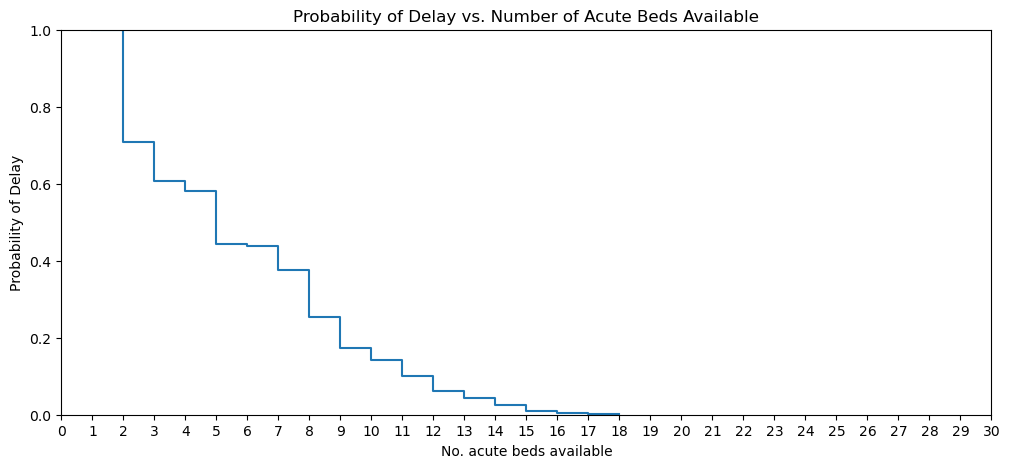

In [4]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

# [Include all the existing classes and functions here: PatientType, Experiment, AcuteStrokeUnit]

def calculate_occupancy_frequencies(occupancy_list):
    unique_values, counts = np.unique(occupancy_list, return_counts=True)
    relative_freq = counts / len(occupancy_list)
    cumulative_freq = np.cumsum(relative_freq)
    return relative_freq, cumulative_freq, unique_values

def calculate_prob_delay(relative_freq, cumulative_freq):
    rel_freq = np.array(relative_freq)
    cum_freq = np.array(cumulative_freq)
    return rel_freq / cum_freq

def prob_delay_plot(prob_delay, unique_values, x_label="No. acute beds available", figsize=(12, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.step(unique_values, prob_delay, where='post')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Probability of Delay")
    ax.set_title("Probability of Delay vs. Number of Acute Beds Available")
    ax.set_xticks(range(0, 31))
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 1)
    return fig, ax

def run_model_and_plot():
    # Create the experiment
    experiment = Experiment({
        'run_length': 365*5,  # Run for 5 years
        'trace': False,  # Set to True if you want to see detailed logs
        'acute_audit_interval': 1  # Audit every 1 day
    })

    # Create the simulation environment
    env = simpy.Environment()

    # Create the AcuteStrokeUnit
    asu = AcuteStrokeUnit(env, experiment)

    # Start the audit process
    env.process(experiment.audit_acute_occupancy(env, experiment.params['acute_audit_interval'], asu))

    # Run the model
    asu.run()

    # Print the results
    print(f"Simulation completed. Run length: {experiment.params['run_length']} days")
    print(f"Total arrivals: {asu.total_arrivals}")
    print(f"Final occupancy: {asu.occupancy}")
    print(f"Number of occupancy audits: {len(experiment.asu_occupancy)}")
    print(f"Average occupancy: {sum(experiment.asu_occupancy) / len(experiment.asu_occupancy):.2f}")
    print(f"Maximum occupancy: {max(experiment.asu_occupancy)}")
    print(f"Minimum occupancy: {min(experiment.asu_occupancy)}")
    print(f"Simulation time at end of run: {env.now = }")

    for patient_type in asu.patient_types.values():
        print(f"Total {patient_type.name} arrivals: {patient_type.count}")

    # Calculate occupancy frequencies
    rel_freq, cum_freq, unique_vals = calculate_occupancy_frequencies(experiment.asu_occupancy)

    # Calculate probability of delay
    prob_delay = calculate_prob_delay(rel_freq, cum_freq)

    # Create and display the probability of delay plot
    fig, ax = prob_delay_plot(prob_delay, unique_vals)
    plt.show()

if __name__ == "__main__":
    run_model_and_plot()


In [8]:
# added by tester
print(f'{len(default_experiment_params.asu_occupancy)=}')
print(f'{env.now=}')

len(default_experiment_params.asu_occupancy)=1824
env.now=1825


## Testing
* **Results processing 1**: code correctly calculates relative and cumulative frequencies
    * Expected result: for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
    * Actual result (PASS): for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
* **Results processing 2**: test that prob delay is calculated correctly.
    * Expected result: The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
    * Actual result (PASS): The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
* **Results collection test 1**: Test the result collection process for ASU collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 2**: Test ASU ward occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range in the range 0 to 50 with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are in the range in the range 0 to 50 with sensible moments.
* **Suppress simulated trace**: Test that setting experiment.trace = False suppresses output by default.
    * Expected result: The model runs with no simulated log output
    * Actual result (PASS): The model runs with no simulated log output
* **Testing lognormal function**: Test that lognomal function correctly calculates the moments of the underlying normal dist.
    * Expected result: The LLM generated function and `sim-tools.distributions.Lognormal` perform the same conversion.
    * Actual results (PASS):  The functions generate the same values.
* **Extreme value test 1**: TIA, Complex Neuro, Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the model is "Accident and Emergency."
* **Extreme value test 2**: All patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Different run length**: The run length of the model is set to 10 days.
    * Expected result: The model should runs no longer than 10 simulated time periods
    * Actual result (PASS): The model runs no longer than 10 simulated time periods
* **Extreme value test 3**: All patient types have have their mean length of stay time set to $M$ a very large number
    * Expected result: No patients depart the model (only arrivals seen in log)
    * Actual Results (PASS): No patients depart the model.
* **Extreme value test 4**: All patient types apart from stroke->rehab have have their mean length of stay time set to $M$ a very large number
    * Expected result: Only stroke patients depart the model (seen in log)
    * Actual Results (PASS): Only stroke patient depart the model.

### Results processing 1

Test that the code correctly calculates the relative and cumulative frequencies of a python list of integer values.

(PASS)

In [5]:
def result_processing_test_1(values, rel_expected, cum_expected):
    '''
    Test the `calculate_occupancy_frequencies` function works
    as expected.

    Expected result: relative frequencies and cumulative freqs
    are the same as expected values.

    Params:
    ------
    values: list
        list of values to test

    rel_expected: list
        list of floats - expected relative freqs

    cum_expected: list
        list of floats - expected cumulative freqs

    Returns:
    -------
    bool: does the model pass the test.
    '''
    rel, cum, unique = calculate_occupancy_frequencies(values)
    # use all close to allow for minor floating point differences.
    return (set(rel) == set(rel_expected)) and  np.allclose(np.array(cum_expected), cum)

In [6]:
result_processing_test_1(values=[1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
                         rel_expected=[0.4, 0.3, 0.2, 0.1],
                         cum_expected=[0.4, 0.7, 0.9, 1.0])

True

### Results Processing test 2

Test that the calculation of the probability of delay is correct.

(PASS)

In [7]:
def result_processing_test_2(relative, cum, p_delay_expected):
    '''
    Test the probability of delay is calculated correctly.
    
    Params:
    ------
    relative: list
        list of floats - relative freqs

    cum: list
        list of floats - cumulative freqs

    Returns:
    -------
    bool: does the function pass the test.
    '''
    p_delay = calculate_prob_delay(relative, cum)
    # use all close to allow for minor floating point differences.
    return np.allclose(np.array(p_delay_expected), p_delay)

In [8]:
relative = [0.4, 0.3, 0.2, 0.1],
cum = [0.4, 0.7, 0.9, 1.0]
expected = [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
result = result_processing_test_2(relative, cum, expected)
result

True

### Results collection test 1

Test the optional results collection process works correctly.  The process should collect acute stroke occupancy every day

(PASS)

In [9]:
def results_collection_test1(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: len(experiment.asu_occupancy) == env.now

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the experiment
    experiment = Experiment({
        'run_length': 365*5,  # Run for 5 years
        'trace': False,  # Set to True if you want to see detailed logs
        'acute_audit_interval': audit_interval  # Audit interval as specified
    })

    # Create the simulation environment
    env = simpy.Environment()

    # Create the AcuteStrokeUnit
    asu = AcuteStrokeUnit(env, experiment)

    # Start the audit process
    env.process(experiment.audit_acute_occupancy(env, experiment.params['acute_audit_interval'], asu))

    # Run the model
    asu.run()

    print(f"Number of occupancy audits: {len(experiment.asu_occupancy)}")
    print(f'Simulation time: {env.now}')
    
    # The number of audits should be equal to the simulation time
    # (assuming audit_interval=1 and the first audit happens at time 1)
    return len(experiment.asu_occupancy) == (env.now - 1)


In [10]:
results_collection_test1()

Number of occupancy audits: 1824
Simulation time: 1825


True

### Result collection test 2

In [11]:
def results_collection_test2(audit_interval=1):
    '''
    Test function to calculate and print statistics about ASU occupancy.

    Parameters:
    -----------
    run_length : int
        The duration of the simulation in days. Default is 5 years (1825 days).
    audit_interval : int
        The interval at which occupancy is recorded. Default is 1 day.

    Returns:
    --------
    dict
        A dictionary containing the calculated statistics.
    '''
    # Create the experiment
    experiment = Experiment({
        'trace': False,
        'acute_audit_interval': audit_interval
    })

    # Create the simulation environment
    env = simpy.Environment()

    # Create the AcuteStrokeUnit
    asu = AcuteStrokeUnit(env, experiment)

    # Start the audit process
    env.process(experiment.audit_acute_occupancy(env, experiment.params['acute_audit_interval'], asu))

    # Run the model
    asu.run()

    # Calculate statistics
    min_occupancy = min(experiment.asu_occupancy)
    max_occupancy = max(experiment.asu_occupancy)
    mean_occupancy = statistics.fmean(experiment.asu_occupancy)
    deciles = [round(q, 1) for q in statistics.quantiles(experiment.asu_occupancy, n=10)]

    # Print results
    print(f'Minimum occupancy: {min_occupancy}')
    print(f'Maximum occupancy: {max_occupancy}')
    print(f'Mean occupancy: {mean_occupancy:.2f}')
    print(f'Deciles of occupancy: {deciles}')


In [12]:
results_collection_test2()

Minimum occupancy: 1
Maximum occupancy: 19
Mean occupancy: 8.35
Deciles of occupancy: [5.0, 6.0, 7.0, 8.0, 8.0, 9.0, 10.0, 11.0, 12.0]


## Test suppress trace

(PASS)

In [13]:
def test_suppress_log(trace):
    '''
    Test that setting experiment.trace 
    False suppresses output.

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''
    def main(params=None):
        experiment = Experiment({'trace': trace})
        env = simpy.Environment()
        model = AcuteStrokeUnit(env, experiment)
        model.run()
    
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    
    if __name__ == "__main__":
        main()


In [14]:
test_suppress_log(trace=False)


Simulation completed.
Total simulation time: 1825.00 days
Total patient arrivals: 2800
Total Stroke arrivals: 1505
Total TIA arrivals: 187
Total Complex Neurological arrivals: 525
Total Other arrivals: 583


### Lognormal test

Test that lognomal function correctly calculates the moments of the underlying normal dist.

**Result: PASS**

In [15]:
def test_lognormal_moments(mean, std):
    '''
    Test that lognomal function correctly calculates 
    the moments of the underlying normal dist.

    Params:
    ------
    mean: float
        mean of the lognormal distribution

    std: float
        st dev of the lognormal distribution

    Returns:
    -------
    bool
    '''
   
    # Lognormal class from sim-tools.
    expected_moments = Lognormal(mean, std)
    print(expected_moments.mu, expected_moments.sigma)

    # Convert lognormal parameters from llm
    normal_mean = math.log(mean**2 / math.sqrt(std**2 + mean**2))
    normal_std = math.sqrt(math.log(1 + (std**2 / mean**2)))
    print(normal_mean, normal_std)

    return (normal_mean, normal_std) == (expected_moments.mu, expected_moments.sigma)

In [16]:
test_lognormal_moments(128.79, 267.51)

4.022977459259615 1.2924439729790718
4.022977459259615 1.2924439729790718


True

### Extreme value test 1

The model uses hard coded parameters.  The most simple way to modify the code for this test was to change hard coded parameters for $M$

**Result: PASS**

In [19]:
M = 10_000_000

In [20]:
def ev_test_1(large_number):
    '''
    TIA, Complex Neuro, Other, have their inter-arrival 
    time set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the model 
    is "Stroke". This is seen in the event log

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''

    def main(arrival_rates=None, run_length=None):
        custom_params = {}
        
        if arrival_rates:
            custom_params['patient_types'] = arrival_rates
        
        if run_length:
            custom_params['run_length'] = run_length
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        model = AcuteStrokeUnit(env, experiment)
        model.run()
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    
    if __name__ == "__main__":
        large_number = M
        
        asu_arrival_rates = {
            'Stroke': {'interarrival_time': 1.2},
            'TIA': {'interarrival_time': large_number},
            'Complex Neurological': {'interarrival_time': large_number},
            'Other': {'interarrival_time': large_number}
        }
    
    main(asu_arrival_rates, run_length=2*365)  # Run for 2 years with custom parameters


In [21]:
ev_test_1(M)


Simulation completed.
Total simulation time: 730.00 days
Total patient arrivals: 564
Total Stroke arrivals: 564
Total TIA arrivals: 0
Total Complex Neurological arrivals: 0
Total Other arrivals: 0


### Extreme value test 2

* An experiment is setup so that all patient types have a mean inter-arrival rate of $M$

**Result: PASS**

In [22]:
def ev_test_2(large_number):
    '''
    All patient types have have their inter-arrival time is 
    set to $M$ a very large number
    
    Expected result: No patients arrive to the model.
    
    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''

    def main(arrival_rates=None, run_length=None):
        custom_params = {}
        
        if arrival_rates:
            custom_params['patient_types'] = arrival_rates
        
        if run_length:
            custom_params['run_length'] = run_length
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        model = AcuteStrokeUnit(env, experiment)
        model.run()
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    
    if __name__ == "__main__":
        large_number = M
        
        asu_arrival_rates = {
            'Stroke': {'interarrival_time': large_number},
            'TIA': {'interarrival_time': large_number},
            'Complex Neurological': {'interarrival_time': large_number},
            'Other': {'interarrival_time': large_number}
        }
    
    main(asu_arrival_rates, run_length=2*365)  # Run for 2 years with custom parameters


In [23]:
ev_test_2(M)


Simulation completed.
Total simulation time: 730.00 days
Total patient arrivals: 0
Total Stroke arrivals: 0
Total TIA arrivals: 0
Total Complex Neurological arrivals: 0
Total Other arrivals: 0


### Different run length test

The model has again been modified to use the original code and parameters generated by the LLM.

In [24]:
TEN_DAYS = 10

In [25]:
def test_run_length(run_length):
    '''
    Test that the run length of the model can be modified.
    
    Expected result: The model should runs no longer than the new run length.

    Params:
    ------
    run_length: float
        Run length of the model in days.

    Returns:
    -------
    float
        Simulation end time.
    '''
    def main(run_length=None):
        custom_params = {}
        
        if run_length:
            custom_params['run_length'] = run_length
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        model = AcuteStrokeUnit(env, experiment)
        model.run()
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    if __name__ == "__main__":
        main(run_length=run_length)


In [26]:
test_run_length(TEN_DAYS)


Simulation completed.
Total simulation time: 10.00 days
Total patient arrivals: 9
Total Stroke arrivals: 2
Total TIA arrivals: 0
Total Complex Neurological arrivals: 5
Total Other arrivals: 2


### Extreme value test 3

* An experiment is setup so that all patient types have a mean length of stay on the ASU of $M$

**Result: PASS**

In [27]:
def ev_test_3(large_number):
    '''
    All patient types have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: No patients depart the model 
    (only arrivals seen in log)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    def main(los_params=None, run_length=None, trace=True):
        custom_params = {'patient_types': {}}
        
        if los_params:
            for patient_type, los in los_params.items():
                if patient_type not in custom_params['patient_types']:
                    custom_params['patient_types'][patient_type] = {}
                custom_params['patient_types'][patient_type]['los_params'] = los
        
        if run_length:
            custom_params['run_length'] = run_length

        
        if trace:
            custom_params['trace'] = True
            
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        model = AcuteStrokeUnit(env, experiment)
        model.run()
    
        # Print results
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        print(f"Total occupancy: {model.occupancy}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")

        return model  # Return the model so we can access its attributes

    # New length of stay parameters - stdev is default
    new_los_params = {
        'Stroke': {'Rehab': (large_number, 8.6), 'ESD': (large_number, 4.8), 'Other': (large_number, 8.7)},
        'TIA': (large_number, 5.0),
        'Complex Neurological': (large_number, 5.0),
        'Other': (large_number, 5.2)
    }

    # Run the simulation with new parameters
    model = main(los_params=new_los_params, run_length=2*365)

    # Check if the total number of arrivals is greater than the final occupancy
    total_arrivals = model.total_arrivals
    final_occupancy = model.occupancy

    return total_arrivals == final_occupancy


In [28]:
result = ev_test_3(M)

Time 0.22: Patient 0 (Stroke) arrived
  Total arrivals: 1
  Stroke arrivals: 1
  Post-ASU destination: Rehab
  Next Stroke arrival in 0.22 days
  Current occupancy: 1
Time 0.22: Patient 0 (Stroke) starting acute treatment
  Length of stay: 9999978.09 days
Time 0.78: Patient 1 (Stroke) arrived
  Total arrivals: 2
  Stroke arrivals: 2
  Post-ASU destination: Other
  Next Stroke arrival in 0.56 days
  Current occupancy: 2
Time 0.78: Patient 1 (Stroke) starting acute treatment
  Length of stay: 9999989.74 days
Time 1.53: Patient 2 (Other) arrived
  Total arrivals: 3
  Other arrivals: 1
  Post-ASU destination: Other
  Next Other arrival in 1.53 days
  Current occupancy: 3
Time 1.53: Patient 2 (Other) starting acute treatment
  Length of stay: 9999994.60 days
Time 1.91: Patient 3 (TIA) arrived
  Total arrivals: 4
  TIA arrivals: 1
  Post-ASU destination: Other
  Next TIA arrival in 1.91 days
  Current occupancy: 4
Time 1.91: Patient 3 (TIA) starting acute treatment
  Length of stay: 10000001

In [31]:
result

True

### Extreme value test 4

* An experiment is setup so that all patient types other than stroke->rehab have a mean length of stay on the ASU of $M$

**Result: PASS**

In [29]:
def ev_test_4(large_number):
    '''
    All patient types apart from stroke-rehab patients
    have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: Only stroke patients depart the
    model.
    (only arrivals seen in log)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    
    def main(los_params=None, run_length=None, trace=True):
        custom_params = {'patient_types': {}}
        
        if los_params:
            for patient_type, los in los_params.items():
                if patient_type not in custom_params['patient_types']:
                    custom_params['patient_types'][patient_type] = {}
                custom_params['patient_types'][patient_type]['los_params'] = los
        
        if run_length:
            custom_params['run_length'] = run_length

        if trace:
            custom_params['trace'] = True
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        model = AcuteStrokeUnit(env, experiment)
        model.run()
    
        # Print results
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        print(f"Total occupancy: {model.occupancy}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")

        return model  # Return the model so we can access its attributes

    # New length of stay parameters - stdev is default
    new_los_params = {
        'Stroke': {'Rehab': (7.4, 8.6), 'ESD': (large_number, 4.8), 'Other': (large_number, 8.7)},
        'TIA': (large_number, 5.0),
        'Complex Neurological': (large_number, 5.0),
        'Other': (large_number, 5.2)
    }

    # Run the simulation with new parameters
    model = main(los_params=new_los_params, run_length=2*365)

    # Check if the total number of arrivals is greater than the final occupancy
    total_arrivals = model.total_arrivals
    final_occupancy = model.occupancy

    return total_arrivals > final_occupancy


In [30]:
results = ev_test_4(M)

Time 3.13: Patient 0 (Complex Neurological) arrived
  Total arrivals: 1
  Complex Neurological arrivals: 1
  Post-ASU destination: Other
  Next Complex Neurological arrival in 3.13 days
  Current occupancy: 1
Time 3.13: Patient 0 (Complex Neurological) starting acute treatment
  Length of stay: 9999996.38 days
Time 3.42: Patient 1 (Stroke) arrived
  Total arrivals: 2
  Stroke arrivals: 1
  Post-ASU destination: Rehab
  Next Stroke arrival in 3.42 days
  Current occupancy: 2
Time 3.42: Patient 1 (Stroke) starting acute treatment
  Length of stay: 3.04 days
Time 4.94: Patient 2 (Stroke) arrived
  Total arrivals: 3
  Stroke arrivals: 2
  Post-ASU destination: ESD
  Next Stroke arrival in 1.52 days
  Current occupancy: 3
Time 4.94: Patient 2 (Stroke) starting acute treatment
  Length of stay: 9999993.12 days
Time 4.98: Patient 3 (Stroke) arrived
  Total arrivals: 4
  Stroke arrivals: 3
  Post-ASU destination: Rehab
  Next Stroke arrival in 0.04 days
  Current occupancy: 4
Time 4.98: Patien

In [31]:
results

True